In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
import os

from collections import defaultdict
from time import time
from os import makedirs
from os.path import join, isdir
from glob import glob

sys.path.append('scripts')
from model_helpers import *
from data_helpers import *
from train_helpers import *


from keras.callbacks import TensorBoard

%load_ext autoreload
%autoreload 2

os.environ['CUDA_VISIBLE_DEVICES']='1'

In [2]:
IMGS_PATH = r'G:\Datasets\carpet_512by512\train\good'
OUT_PATH = r'saved\logs'
if not isdir(OUT_PATH):
    makedirs(OUT_PATH)

# Hyperparameters

In [3]:
patch_size = (128, 128)
center_size = (32, 32)
num_train_test = num_test_test = 2   # 10
batch_size = 23      #128
# num_epochs = 500
num_epochs = 2
model_width = 1

In [4]:
# # Glob for '*.jpg' files
# files = glob(join(IMGS_PATH, '*.png'))

# # Print the files to see what is being returned
# print(f"Number of '*.jpg' files found: {len(files)}")
# print(files)

# Load data

In [4]:
files = np.random.choice(glob(join(IMGS_PATH, '*.png')), 23, replace=False)
train_files = files[ : -(num_train_test + num_test_test)]
train_test_files, test_test_files = files[-(num_train_test + num_test_test):-num_test_test], files[-num_test_test:]
# fake_files = glob('data/fake_files/*.png')
# fake_files = glob(r'G:\CO4001_eng_project\Datasets\mvtech_anomaly_detection\carpet\test\hole\*.png')
fake_files = glob(r'G:\Datasets\carpet_512by512\test\hole\*.png')


In [5]:
print('Number of training files:', len(train_files))
print('Number of train-test files:', len(train_test_files))
print('Number of test-test files:', len(test_test_files))
print('Number of fake files:', len(fake_files))

imgss = defaultdict(list)
start = time()
for dataset, files in zip(['train', 'train_test', 'test_test', 'fake'], 
                          [train_files, train_test_files, test_test_files, fake_files]):
    for i, f in enumerate(files):
        imgss[dataset].append(cv2.imread(f, 0))

        if i % 1000 == 0 and i != 0:
            end = time()
            print('Processing dataset {}: {:.0f} sec - ETA: {:.0f} sec'.format(
                dataset, end-start, ((end-start) / (i + 1)) * (len(files) - i)))
# print(imgss['train'][0].shape)
# print(imgss['train'])
#this means: dictionary imgss has 4 keys: train, train_test, test_test, fake and each key has a list of images (list of arrays of grey scale)
# i.e. like { 'train': [array1, array2, array3, ...], 'train_test': [array1, array2, array3, ...], ...}

Number of training files: 19
Number of train-test files: 2
Number of test-test files: 2
Number of fake files: 17


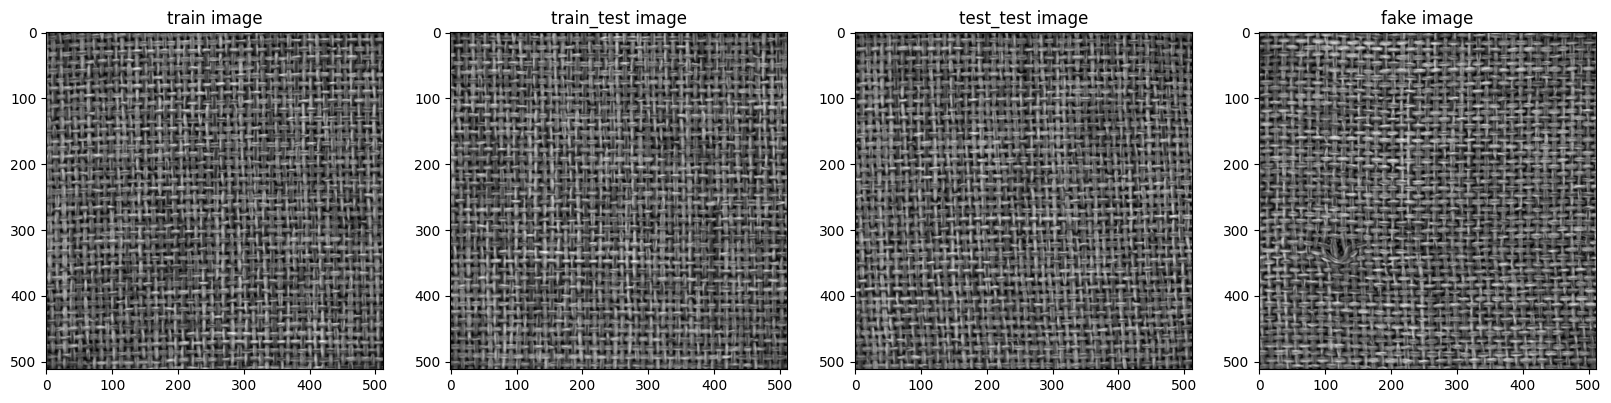

In [7]:
fig, ax = plt.subplots(1, len(imgss.keys()), figsize=(20, 30))
for i, (dataset, imgs) in enumerate(imgss.items()):
    ax[i].imshow(imgs[0], 'gray')
    ax[i].set_title('{} image'.format(dataset))

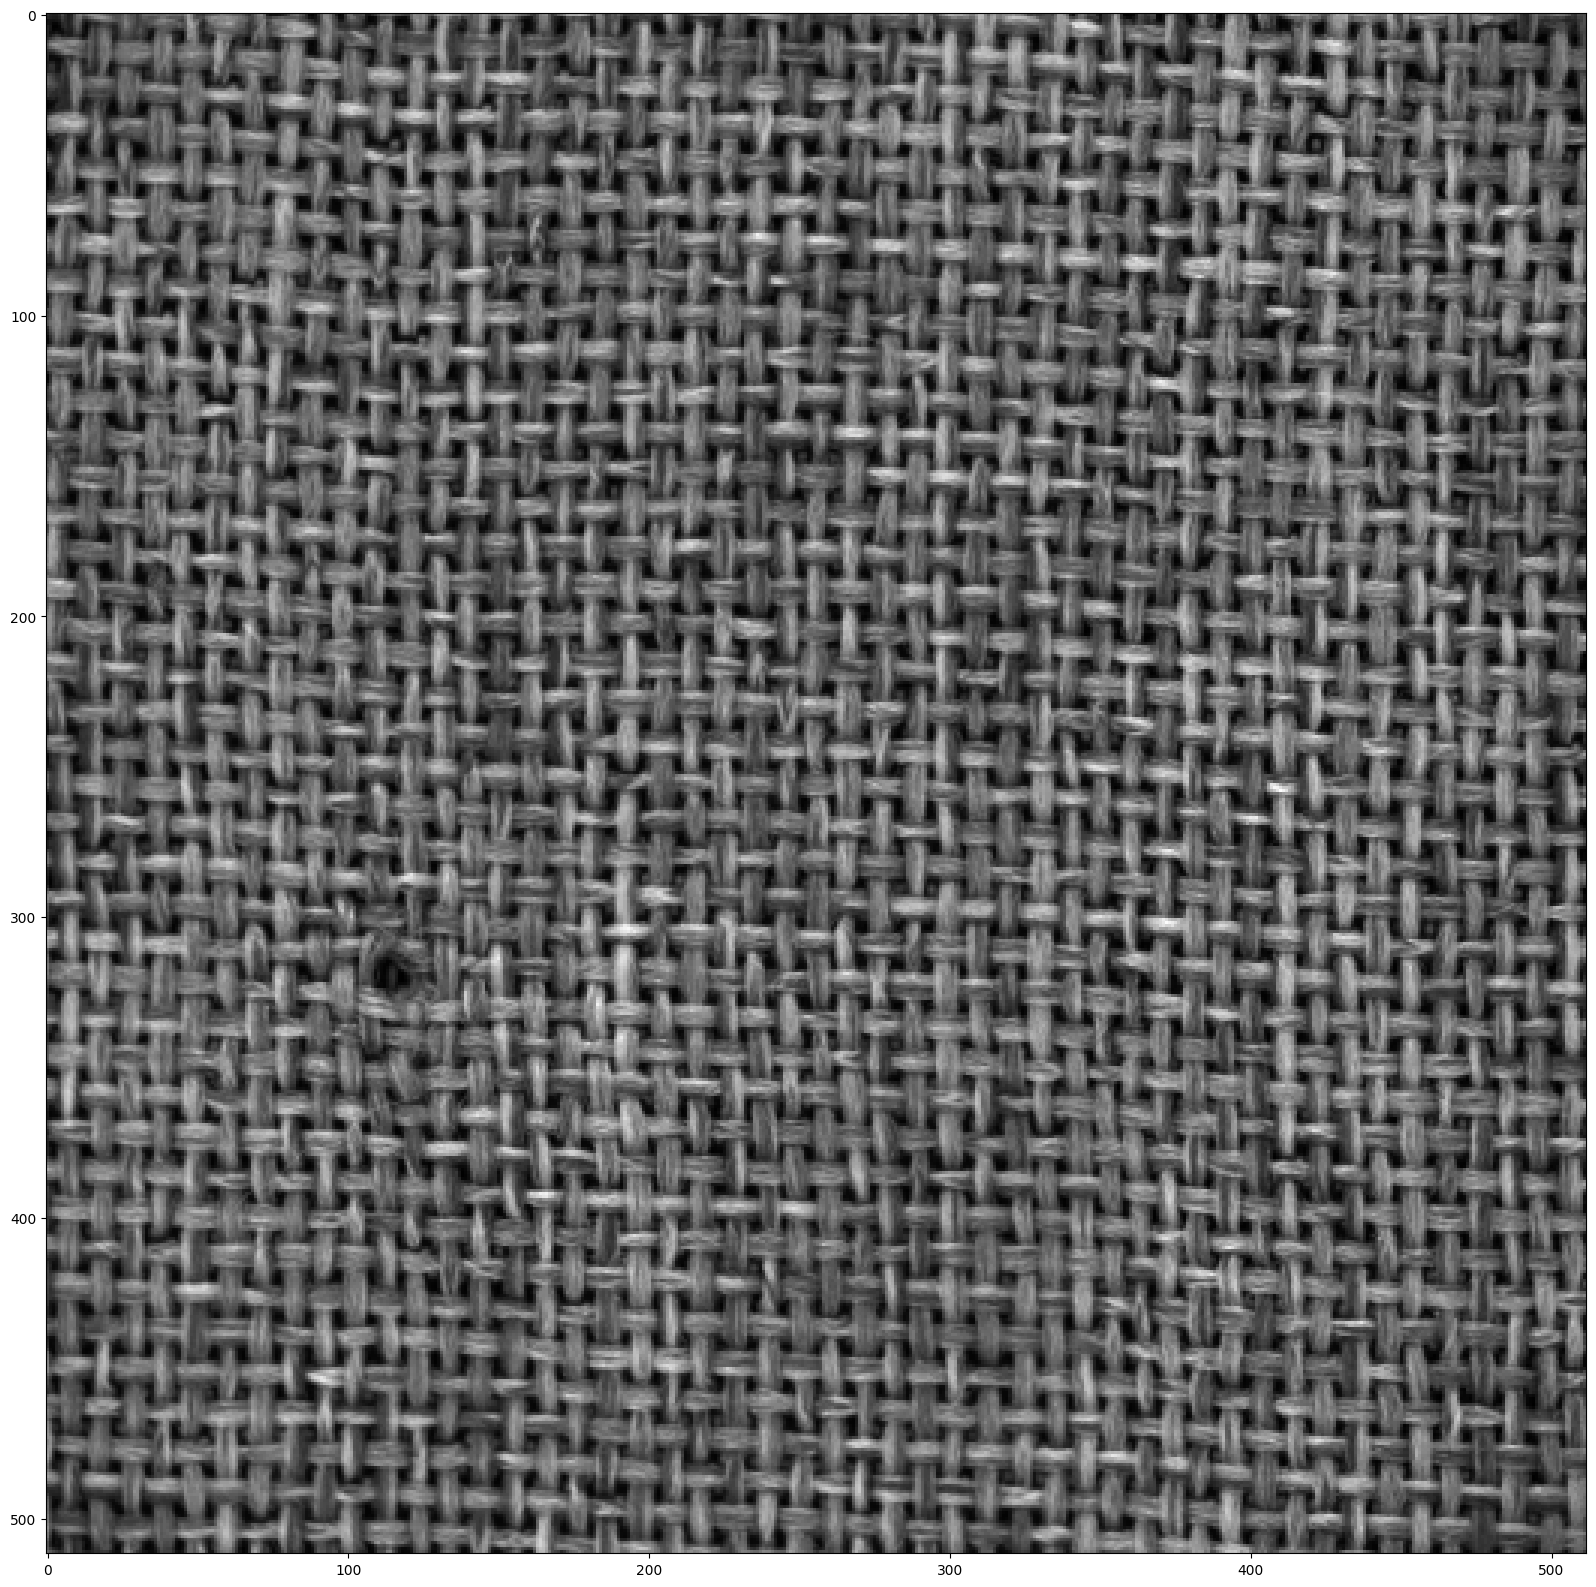

In [8]:
plt.figure(figsize=(30, 20))
plt.imshow(imgss['fake'][1], 'gray')

## Square images and resize to same size

In [6]:
for dataset, imgs in imgss.items():
    res_imgs = [img[:min(img.shape), :min(img.shape)] for img in imgs] 
    min_size = np.min([img.shape[0] for img in res_imgs])

    res_imgs = [cv2.resize(img, (min_size, min_size), interpolation=cv2.INTER_CUBIC) for img in res_imgs]
    imgss[dataset] = np.expand_dims(res_imgs, axis=3)

print(len(imgss['train']))

19


## Create training generator and evaluation images

1
2
12


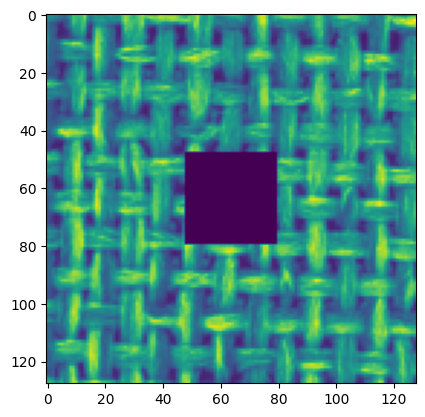

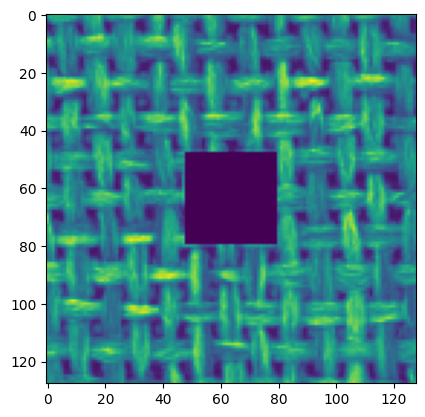

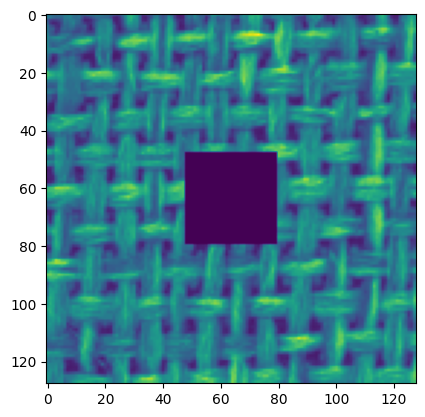

In [26]:
# train_generator = DataGenerator(imgss['train'], patch_size, center_size, batch_size=batch_size, shuffle=True)
train_generator = DataGenerator(imgss['train'], patch_size, center_size, batch_size=12, shuffle=True)

batch = train_generator[0]   # get first batch
images_batch = batch[0]      # get a batch of image patches of a single image

# Displaying the first image in the batch
first_image = images_batch[0]   # get the first path of the image patches

# Assuming first_image is a single image or an array representing an image
print(len(train_generator))
print(len(batch))
print(len(images_batch))
for img in images_batch[0:3]:
    plt.imshow(img)
    plt.show()

In [8]:
x_test = []
for patches in patchess.values():
    x_test.extend(patches)
x_test = np.array(x_test)

In [7]:
mask = create_center_mask(patch_size, center_size)
patchess = defaultdict(list)
for i, (dataset, imgs) in enumerate(imgss.items()):
    if dataset != 'train':
        for j, img in enumerate(imgs):
            patchess[dataset].append(prepare_patch(img, patch_size, mask, i + j))

# print(len(patchess['fake']))
# for patch in patchess['fake']:
#     print(patch.shape)
#     plt.imshow(patch)
#     plt.show()

In [ ]:
plt.imshow(np.squeeze(patchess['fake'][3]), 'gray')

# Create model

In [30]:
model = create_anomaly_cnn(model_width=model_width)

In [9]:
model.patch_size = patch_size
model.center_size = center_size
model.batch_size = batch_size
model.num_epochs = num_epochs
model.model_width = model_width

NameError: name 'model' is not defined

In [ ]:
model.summary()

In [32]:
model.compile(optimizer='adam', loss=reconstruction_loss(patch_size, mask=mask), metrics=['accuracy'])

In [10]:
images_callback = TensorBoardImages(OUT_PATH, patchess, vis_every=1)
checkpoint_callback = CustomModelCheckpoint(OUT_PATH, save_weights_only=False)
losses_callback = TensorBoard(log_dir=OUT_PATH, batch_size=batch_size)

In [37]:
history_dict = model.fit(
                  train_generator,
                  validation_data=(x_test, x_test),
                  epochs=1,
                  verbose=1,
                  callbacks=[images_callback, checkpoint_callback, losses_callback], 
                  # callbacks=[ checkpoint_callback, losses_callback], 
                  workers=10,
                  use_multiprocessing=True,
                  shuffle=False,
                  initial_epoch=0
               )

1/1 [==============================] - 1s 1s/step


g:\CO4001_eng_project\Codes\anomaly-detection-image-completion-master\env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 140s 140s/step - loss: 6.0974e-04 - accuracy: 0.0625 - val_loss: 0.0012 - val_accuracy: 0.0000e+00


save model

In [41]:
# Assuming 'model' is your trained model object
model_path = 'g:/CO4001_eng_project/trained_models'
model.save(f'{model_path}/model1.keras')

testing 

In [16]:

data_generator = TestDataGenerator(patch_size, center_size)
patches = data_generator.generate_patches(imgss['fake'][0])

In [ ]:
for img in patches:
    plt.imshow(img)
    plt.show()

loading model

In [ ]:
from tensorflow.keras.models import load_model

model_path = 'g:/CO4001_eng_project/trained_models'
# Define custom_objects dictionary with your custom objects
custom_objects = {'reconstruction_loss': reconstruction_loss}

# Load the model
loaded_model = load_model(f'{model_path}/model1.keras', custom_objects={'reconstruction_loss': reconstruction_loss}, safe_mode=False )
loaded_model.summary()

Prediction

In [37]:

print(len(patches))
print(patches[0].shape)


input_patch = np.expand_dims(patches[0], axis=0)
reconstructed_patch = loaded_model(input_patch)
print(len(reconstructed_patch))

reconstructed_patch = np.squeeze(reconstructed_patch, axis=0)
print(reconstructed_patch.shape)

plt.imshow(patches[0])  # Assuming it's a grayscale image
plt.show()

plt.imshow(reconstructed_patch[:,:,0])  # Assuming it's a grayscale image
plt.show()

reconstructed_patches = []
# for i in range(len(patches)):

#     plt.imshow(reconstructed_patch[:,:,0])  # Assuming it's a grayscale image
#     plt.show()

#     reconstructed_patches.append(reconstructed_patch)




512
(128, 128, 1)
1
(128, 128, 1)


Error calculation

plot the error